In [74]:
# cd /content/sample_data

Importing useful libraries

In [75]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
import tensorflow as tf
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn import metrics as sk_metrics
import nltk
import re
from sklearn.utils import shuffle
import tqdm as notebook_tqdm 

# Data read and split...for some accuracy numbers

In [76]:
col = ["id", "tweet", "label"]
our_data = pd.read_csv("vax_train.csv",usecols=col)
df_test = pd.read_csv("vax_test.csv")
y_map = {
    'ProVax': 0, 
    'AntiVax': 1, 
    'Neutral': 2
}

our_data['Sentiment_Cat'] = our_data['label'].map(y_map)

## showing train data

In [77]:
our_data

,id,tweet,label,Sentiment_Cat
0,1329771561671417856,Today Pfizer said it's asking U.S. regulators ...,Neutral,2
1,1266030447919804420,Good news on development of new #covid19 #vacc...,ProVax,0
2,1238769307456172034,Once they get a corona vaccine I don’t want to...,ProVax,0
3,1328814394822705152,Free flu vaccines and COVID-19 tests! https://...,Neutral,2
4,1254610119876280320,"Bollywood Gupshup,Russian Researchers Will Tes...",ProVax,0
...,...,...,...,...
4387,1326106718519128064,"👇👇Not a good practice, not good for public tru...",Neutral,2
4388,1326136835916095493,Something about this vaccine scares me! Anyone...,AntiVax,1
4389,1326186592847982593,@TinkerChip @matthaig1 They have been working ...,ProVax,0
4390,1325792316716625920,Fingers crossed this is positive data.. \n\nPf...,ProVax,0


## showing test data

In [78]:
df_test

,id,tweet
0,1472958183882719233t,So true. Take control of what you can…get vac...
1,1449995880904470529t,The vaccinated still spread it and are factori...
2,1480413964265660416t,"NT records 403 new cases of COVID-19, as it ex..."
3,1408119497962057742t,@ochealth You are experimenting with people. B...
4,1439361704320806915t,@LPCPressBox So I guess we’re supposed to just...
...,...,...
712,1426222975108407296t,@DrunkenDucksFan @maryloupatey @CP24 https://t...
713,1471836133613084672t,"@JustinTrudeau @fordnation Justin, how can you..."
714,1472586840301617153t,@ThatAmish1 Have they seen all of the sporting...
715,1423061697556668420t,@mimij1992 @SClarified @OregonGovBrown @OHAOre...


## Splitting the training dataset into training and validation sets with the help of StratifiedShuffleSplit

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit
df = our_data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_valid_index in split.split(df, df.Sentiment_Cat):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.Sentiment_Cat):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

print(train_set.shape)
print(test_valid_set.shape)
print(test_set.shape)
print(valid_set.shape)

df_train = train_set
# df_test = test_set
df_valid = test_valid_set

(3952, 4)
(440, 4)
(220, 4)
(220, 4)


In [80]:
df_train.head()

,id,tweet,label,Sentiment_Cat
876,1327030820037681152,Powell says economy will still need more suppo...,Neutral,2
3696,1325689685943996416,The Philippine government is in talks with Ang...,Neutral,2
473,1292440252628566016,Happy birthday to Upright Vol. IV! This one fe...,Neutral,2
1981,1246258423014010880,@mitchellvii I was H1N1 positive once but noth...,AntiVax,1
3560,1325830486518882304,@DanCrenshawTX You lie. Pfizer refused governm...,ProVax,0


## Just showing first tweet in our training set.

In [81]:
df_train['tweet'].iloc[0]

'Powell says economy will still need more support despite progress toward COVID-19 vaccine https://t.co/Iv3V1mah0G'

In [82]:
df_test

,id,tweet
0,1472958183882719233t,So true. Take control of what you can…get vac...
1,1449995880904470529t,The vaccinated still spread it and are factori...
2,1480413964265660416t,"NT records 403 new cases of COVID-19, as it ex..."
3,1408119497962057742t,@ochealth You are experimenting with people. B...
4,1439361704320806915t,@LPCPressBox So I guess we’re supposed to just...
...,...,...
712,1426222975108407296t,@DrunkenDucksFan @maryloupatey @CP24 https://t...
713,1471836133613084672t,"@JustinTrudeau @fordnation Justin, how can you..."
714,1472586840301617153t,@ThatAmish1 Have they seen all of the sporting...
715,1423061697556668420t,@mimij1992 @SClarified @OregonGovBrown @OHAOre...


## Converting "sentiment_cat" column into integer for training purpose.

In [83]:
M = {
    'AntiVax': 1, 
    'ProVax': 0, 
    'Neutral': 2
}

df_train['Sentiment_Cat'] = df_train['label'].map(M)
df_valid['Sentiment_Cat'] = df_valid['label'].map(M)

<ipython-input-83-f03b6fd7352b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Sentiment_Cat'] = df_train['label'].map(M)
<ipython-input-83-f03b6fd7352b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Sentiment_Cat'] = df_valid['label'].map(M)


# Pre-processing

In [84]:
!pip install emoji contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import sys
import re
# !pip install emoji --quiet
import emoji
# !pip install contractions --quiet
import contractions
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
import unicodedata

## Given below is the function for Stemmizing and cleaning the tweets from training Dataset.

In [86]:
def cleaning(text):
  text= text.lower()
  text= emoji.demojize(text)
  text=contractions.fix(text)
  text=text.strip()
  text=text.replace('[^\w\s]','')
  text=re.sub(r'http\S+', '', text)
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
  text = REPLACE_BY_SPACE_RE.sub(' ' , text)
  text = BAD_SYMBOLS_RE.sub(' ',text)
  return text


## Cleaning the tweets of Training Data

In [87]:
df_train['tweet_cleaned'] = df_train['tweet'].apply(cleaning)

df_train['tweet_cleaned'].iloc[0]

<ipython-input-87-9021be7e2ec7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet_cleaned'] = df_train['tweet'].apply(cleaning)


'powell says economy will still need more support despite progress toward covid 19 vaccine '

## Cleaning the tweets of Test Data


In [88]:
df_test['tweet_cleaned'] = df_test['tweet'].apply(cleaning)


## Cleaning the tweets of Validation Data


In [89]:
df_valid['tweet_cleaned'] = df_valid['tweet'].apply(cleaning)

<ipython-input-89-61f3d6dc8e04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['tweet_cleaned'] = df_valid['tweet'].apply(cleaning)


## Model Training Starts

In [90]:
x_train, y_train = df_train['tweet_cleaned'].values, np.array(df_train['Sentiment_Cat'], dtype=np.int64)
x_valid, y_valid = df_valid['tweet_cleaned'].values, np.array(df_valid['Sentiment_Cat'], dtype=np.int64)

In [91]:
x_test = df_test['tweet_cleaned'].values

# Data Analysis

In [92]:
data = df_train
Neutral_data = data[data['Sentiment_Cat'] == 2]
Antivax_data = data[data['Sentiment_Cat'] == 1]
Provax_data = data[data['Sentiment_Cat'] == 0]

## How much Antivax_data ?

In [93]:
a=[]
for i in range(len(Antivax_data)):
  a.append(len(Antivax_data['tweet_cleaned'].iloc[i].split()))

## How much Provax data ?

In [94]:
p=[]
for i in range(len(Provax_data)):
  p.append(len(Provax_data['tweet_cleaned'].iloc[i].split()))

##How much Neutral data ?**

In [95]:
n=[]
for i in range(len(Neutral_data)):
  n.append(len(Neutral_data['tweet_cleaned'].iloc[i].split()))

In [96]:
print(len(Neutral_data), len(Antivax_data), len(Provax_data))

1471 973 1508


In [97]:
Antivax_data.head()

,id,tweet,label,Sentiment_Cat,tweet_cleaned
1981,1246258423014010880,@mitchellvii I was H1N1 positive once but noth...,AntiVax,1,mitchellvii i was h1n1 positive once but noth...
2412,1338223969913118721,@bennyjohnson Meanwhile he isn't affected by t...,AntiVax,1,bennyjohnson meanwhile he is not affected by ...
3438,1329050409420419072,I won't be the first!\n\nPfizer coronavirus va...,AntiVax,1,i will not be the first pfizer coronavirus v...
1410,1261409476218765312,@lordofchickenz @akins_lin @ABC7 @Cgriffin3323...,AntiVax,1,lordofchickenz akins lin abc7 cgriffin3323...
4004,1325825579329990660,Great news for the vaccine manufacturers 🤦🏼‍♂️...,AntiVax,1,great news for the vaccine manufacturers man ...


In [98]:
Provax_data.head()

,id,tweet,label,Sentiment_Cat,tweet_cleaned
3560,1325830486518882304,@DanCrenshawTX You lie. Pfizer refused governm...,ProVax,0,dancrenshawtx you lie pfizer refused governm...
961,1325806879671508993,The anti maskers won’t take this vaccine cos t...,ProVax,0,the anti maskers will not take this vaccine co...
1004,1325874804445093896,It will be the fastest vaccine development and...,ProVax,0,it will be the fastest vaccine development and...
2716,1326150499222122497,@sliceandserve The speed drug companies have b...,ProVax,0,sliceandserve the speed drug companies have b...
1423,1325818485721747456,YESSSSS!!! Per aspera ad astra!!! Fantastic n...,ProVax,0,yesssss per aspera ad astra fantastic n...


In [99]:
Neutral_data.head()

,id,tweet,label,Sentiment_Cat,tweet_cleaned
876,1327030820037681152,Powell says economy will still need more suppo...,Neutral,2,powell says economy will still need more suppo...
3696,1325689685943996416,The Philippine government is in talks with Ang...,Neutral,2,the philippine government is in talks with ang...
473,1292440252628566016,Happy birthday to Upright Vol. IV! This one fe...,Neutral,2,happy birthday to upright vol iv this one fe...
2294,1247357106132582400,@kenvogel @sanofi OH GOOD GRIEF. Leftwingers...,Neutral,2,kenvogel sanofi oh good grief leftwingers...
3971,1330902684224798720,How a handful of scientists developed Oxford v...,Neutral,2,how a handful of scientists developed oxford v...


## Representing Frequency of words in each tweet corresponding to Antivax, Provax and neutral Data

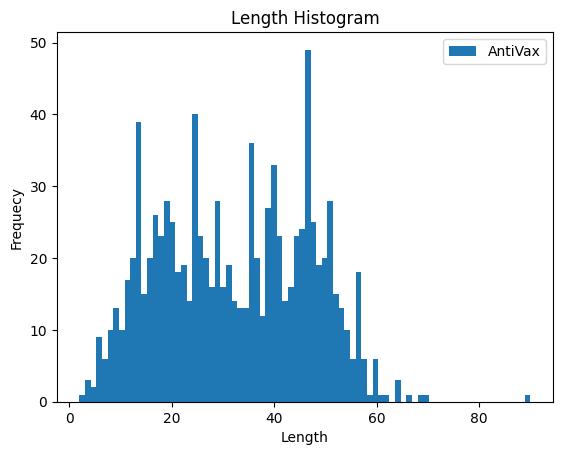

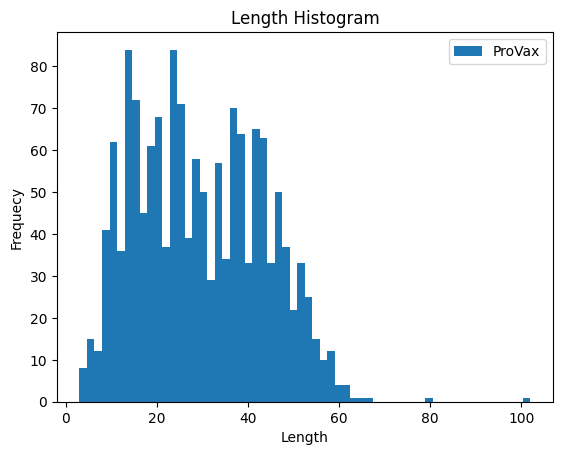

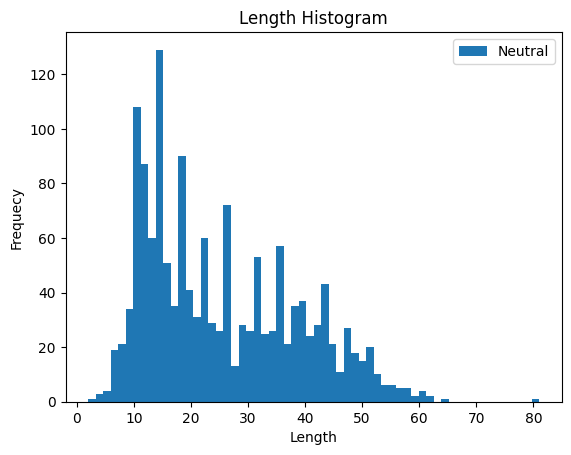

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
plt.hist(a,bins= 80, label = "AntiVax")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(b,bins= 60, label = "ProVax")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(c, bins= 60, label = "Neutral")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()

# BERT

In [101]:
!pip install tokenizers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
from tokenizers import BertWordPieceTokenizer
import transformers

### Tokenization is cutting input data into parts (symbols) that can be mapped (embedded) into a vector space. 

In [103]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased', lower=True)

# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

tokenizer = transformers.BertTokenizerFast.from_pretrained('.')

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

## function for transforming and encoding into vector space

In [104]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=200):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

## Converting train, validation and test data into vector spaces

In [105]:
max_len=80
x_train_enc = fast_encode(x_train, fast_tokenizer, maxlen=max_len)
x_valid_enc = fast_encode(x_valid, fast_tokenizer, maxlen=max_len)
x_test_enc = fast_encode(x_test, fast_tokenizer, maxlen=max_len)


## Compiling the bert *model*

In [106]:
NUM_CLASSES = df_train['Sentiment_Cat'].nunique()

bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2', num_labels=NUM_CLASSES)

input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
sequence_output = bert_transformer(input)[0]

model = tf.keras.Model(inputs=input, outputs=sequence_output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### summary of the model

In [107]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80)]              0         
                                                                 
 tf_bert_for_sequence_classi  TFSequenceClassifierOutp  335144963
 fication_1 (TFBertForSequen  ut(loss=None, logits=(No           
 ceClassification)           ne, 3),                             
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
Total params: 335,144,963
Trainable params: 335,144,963
Non-trainable params: 0
_________________________________________________________________


## 

## Fitting the model

In [108]:
history = model.fit(
    x_train_enc,
    y_train,
    batch_size=16,
    validation_data=(x_valid_enc, y_valid),
    epochs=15)

Epoch 1/15
247/247 [==============================] - 319s 889ms/step - loss: 1.0681 - accuracy: 0.4188 - val_loss: 1.0788 - val_accuracy: 0.3909
Epoch 2/15
247/247 [==============================] - 212s 857ms/step - loss: 1.0591 - accuracy: 0.4081 - val_loss: 1.0667 - val_accuracy: 0.4000
Epoch 3/15
247/247 [==============================] - 210s 850ms/step - loss: 0.8973 - accuracy: 0.5787 - val_loss: 0.6855 - val_accuracy: 0.7000
Epoch 4/15
247/247 [==============================] - 210s 851ms/step - loss: 0.5634 - accuracy: 0.7837 - val_loss: 0.5577 - val_accuracy: 0.7795
Epoch 5/15
247/247 [==============================] - 207s 840ms/step - loss: 0.4100 - accuracy: 0.8494 - val_loss: 0.5342 - val_accuracy: 0.7773
Epoch 6/15
247/247 [==============================] - 210s 850ms/step - loss: 0.3024 - accuracy: 0.8925 - val_loss: 0.5306 - val_accuracy: 0.7795
Epoch 7/15
247/247 [==============================] - 210s 850ms/step - loss: 0.1828 - accuracy: 0.9400 - val_loss: 0.5457 -

# USing the model for making prediction on Test Data

In [109]:
ypred = model.predict(x_test_enc)
ypred


23/23 [==============================] - 19s 535ms/step


array([[ 1.2126119 , -3.9775724 ,  1.5869763 ],
       [-1.9894403 ,  5.5352564 , -1.6815636 ],
       [-0.26700097, -3.6828067 ,  2.828733  ],
       ...,
       [-0.9373422 ,  1.2270724 , -0.3168971 ],
       [ 5.2240043 , -2.7014272 , -3.2684827 ],
       [ 0.98601747, -3.6980367 ,  0.8204336 ]], dtype=float32)

## converting real number into numbers 0,1 and 2 reprsenting three classes

In [110]:
print(np.argmax(ypred, axis=1))

[2 1 2 0 2 2 0 0 2 2 1 1 0 0 2 0 2 1 2 0 1 0 1 1 1 2 1 1 1 1 1 1 0 2 1 2 2
 2 0 0 2 0 0 2 1 0 2 0 2 0 2 1 1 0 1 1 0 0 2 0 2 1 2 1 1 0 0 1 1 2 0 0 0 0
 2 0 0 2 0 0 2 2 2 1 0 1 1 2 1 0 0 0 0 1 2 0 2 0 1 0 0 1 0 1 0 1 0 2 2 0 1
 2 0 1 0 0 0 2 0 1 2 1 0 0 2 2 0 1 1 1 2 0 1 0 0 1 1 2 0 0 0 0 0 0 1 2 1 2
 0 0 0 2 1 2 1 0 2 2 0 2 1 2 2 1 0 2 1 0 0 2 1 1 2 0 0 0 2 1 0 0 0 2 2 0 1
 0 2 0 0 0 2 2 1 0 1 0 0 0 1 0 1 2 2 2 0 2 2 2 2 1 0 2 0 1 2 2 1 1 0 2 0 2
 2 0 1 0 2 0 0 0 0 0 1 1 2 0 0 2 0 2 0 0 1 2 0 2 1 2 0 1 2 2 1 0 0 0 0 0 1
 0 2 0 1 2 2 2 0 2 2 2 1 0 1 2 0 0 2 1 2 0 2 0 2 2 2 0 0 0 1 1 1 1 2 1 1 0
 2 1 0 0 0 0 2 2 1 0 0 0 0 2 0 2 1 2 1 0 2 0 1 1 2 0 0 2 0 1 2 0 2 0 0 0 1
 1 1 0 0 2 1 2 1 2 0 0 0 0 1 0 2 0 2 2 2 0 2 2 0 2 2 1 2 1 2 1 2 2 2 1 2 1
 2 2 0 0 2 0 0 0 0 2 2 1 0 0 2 2 0 2 0 2 2 2 1 1 2 0 1 2 0 0 1 2 2 0 2 1 1
 2 0 2 1 0 0 2 1 1 1 2 0 0 0 2 2 0 1 0 1 0 0 0 2 1 0 2 0 2 0 0 2 1 0 2 0 1
 1 0 1 0 2 2 2 0 0 0 2 2 1 0 1 2 2 2 2 2 1 2 1 2 0 1 0 0 2 2 0 0 0 0 0 0 2
 2 2 0 2 0 0 1 2 2 0 2 1 

In [111]:
df_test['ypred'] = np.argmax(ypred, axis=1)
df_test

,id,tweet,tweet_cleaned,ypred
0,1472958183882719233t,So true. Take control of what you can…get vac...,so true take control of what you can get vac...,2
1,1449995880904470529t,The vaccinated still spread it and are factori...,the vaccinated still spread it and are factori...,1
2,1480413964265660416t,"NT records 403 new cases of COVID-19, as it ex...",nt records 403 new cases of covid 19 as it ex...,2
3,1408119497962057742t,@ochealth You are experimenting with people. B...,ochealth you are experimenting with people b...,0
4,1439361704320806915t,@LPCPressBox So I guess we’re supposed to just...,lpcpressbox so i guess we are supposed to jus...,2
...,...,...,...,...
712,1426222975108407296t,@DrunkenDucksFan @maryloupatey @CP24 https://t...,drunkenducksfan maryloupatey cp24 guess w...,0
713,1471836133613084672t,"@JustinTrudeau @fordnation Justin, how can you...",justintrudeau fordnation justin how can you...,1
714,1472586840301617153t,@ThatAmish1 Have they seen all of the sporting...,thatamish1 have they seen all of the sporting...,1
715,1423061697556668420t,@mimij1992 @SClarified @OregonGovBrown @OHAOre...,mimij1992 sclarified oregongovbrown ohaore...,0


## Converting y_pred from number to String Category

In [112]:
M1 = {
    0: 'Provax',
    1: 'Antivax',
    2: 'Neutral'
}
df_test['ypred'] = df_test['ypred'].map(M1)

## Finally Creating Task1_answer.csv file which contains output prediction for each row/ data.

In [113]:
df_test.to_csv("task1_answer.csv")

# Now calcultaing Precision, Recall, F1 score for Validation set

#### Converting validation data into vector spaces

In [114]:
x_val_enc  = fast_encode(x_valid, fast_tokenizer, maxlen=max_len) 

#### Running model for x_val_enc (validation set)

#### Converting real number into numbers 0,1 and 2 reprsenting three classes for Validation data

In [115]:
y_pred_val = model.predict(x_val_enc)
y_pred_val

14/14 [==============================] - 8s 545ms/step


array([[-1.3440373 , -1.0769017 ,  2.3314114 ],
       [ 2.6978436 , -3.889159  ,  0.423849  ],
       [-3.3523328 ,  3.0127406 ,  1.603378  ],
       ...,
       [ 6.2591825 , -3.2070162 , -3.304051  ],
       [ 2.9504476 , -4.2791963 , -0.19849436],
       [ 1.3614838 , -2.3011959 ,  0.44885072]], dtype=float32)

In [116]:
print(np.argmax(y_pred_val, axis=1)) 

[2 0 1 1 2 1 0 1 1 1 2 2 0 2 0 0 0 2 0 2 0 0 0 0 0 2 0 2 0 1 2 0 0 0 0 0 1
 2 2 0 2 0 0 2 0 2 0 2 1 0 2 0 2 1 0 1 1 2 0 0 0 2 2 0 0 1 2 1 0 0 1 2 2 1
 0 0 0 1 0 0 1 1 2 0 1 2 2 1 0 2 1 0 0 2 0 0 2 2 1 2 2 1 0 2 1 0 1 2 2 0 2
 0 0 0 0 0 0 2 0 2 2 2 2 0 2 0 0 2 0 1 1 2 0 1 0 1 0 2 0 2 2 2 0 0 0 1 1 0
 0 2 2 2 1 0 0 0 0 0 1 0 0 0 1 1 0 0 2 2 0 0 2 0 1 1 0 2 2 0 0 1 0 1 0 2 0
 2 2 0 2 1 2 1 0 2 2 0 0 0 0 2 0 2 0 2 2 2 0 2 2 0 0 0 1 0 0 0 2 0 2 2 0 1
 1 2 1 2 0 0 2 1 0 1 0 2 2 0 1 0 0 0 1 2 2 0 1 0 2 0 0 2 0 1 1 1 2 2 2 2 2
 1 1 1 2 1 2 0 0 1 2 1 1 2 2 0 0 0 2 0 1 0 0 0 0 1 0 0 0 0 2 1 0 0 2 2 2 0
 2 2 1 0 0 0 2 0 2 2 1 1 0 1 2 1 0 0 2 1 2 1 0 0 2 2 0 2 1 1 2 0 0 2 2 2 0
 0 1 1 0 0 0 2 2 2 0 1 0 2 2 2 1 0 0 1 1 2 2 2 2 2 2 0 2 0 0 0 2 2 2 2 0 2
 0 1 2 2 2 0 0 0 1 2 0 0 2 1 1 0 0 2 1 1 1 2 0 0 0 0 0 2 2 0 0 0 1 1 0 0 1
 1 1 2 2 2 0 1 0 0 0 0 0 2 2 0 1 0 0 2 0 1 0 1 2 0 1 0 1 2 2 0 0 0]


In [117]:
df_valid['ypred'] = np.argmax(y_pred_val, axis=1)
df_valid

<ipython-input-117-2b5af62e3e3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['ypred'] = np.argmax(y_pred_val, axis=1)


,id,tweet,label,Sentiment_Cat,tweet_cleaned,ypred
691,1307975350383792128,@udchuck @JoMacpherson6 @marklevinshow Read up...,AntiVax,1,udchuck jomacpherson6 marklevinshow read up...,2
107,1325860793783554053,We’d never heard of coronavirus when work bega...,Neutral,2,we would never heard of coronavirus when work ...,0
75,1249710694125076482,@IngrahamAngle I’m curious about the Pneumonia...,Neutral,2,ingrahamangle i am curious about the pneumoni...,1
371,1325822304815894531,No way im letting that mass murderer Bill Gate...,AntiVax,1,no way i am letting that mass murderer bill ga...,1
1663,1325684180483600384,Moderna on track to report late-stage COVID-19...,Neutral,2,moderna on track to report late stage covid 19...,2
...,...,...,...,...,...,...
2696,1333442672871284742,Moderna to ask health regulators to authorize ...,Neutral,2,moderna to ask health regulators to authorize ...,2
1856,1268940950908424199,@leventkemaI probabalistic Political solution ...,Neutral,2,leventkemai probabalistic political solution ...,2
26,1325878299936120838,Good News: Pfizer COVID-19 vaccine 90 percent ...,ProVax,0,good news pfizer covid 19 vaccine 90 percent ...,0
4295,1271896099570114562,friendly reminder: covid isn’t over. there’s n...,ProVax,0,friendly reminder covid is not over there is...,0


## Confusion Matrix of Validation Set

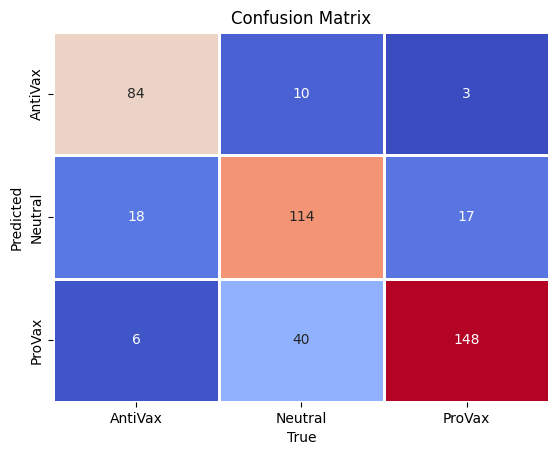

In [118]:
y_map_inv = {
    0: 'ProVax',
    1: 'AntiVax',
    2: 'Neutral'
}

sns.heatmap(
    pd.crosstab(df_valid['ypred'].map(y_map_inv), df_valid['Sentiment_Cat'].map(y_map_inv)),
    annot=True,
    fmt='0.0f',
    cbar=False,
    linewidth=2,
    cmap='coolwarm'     
)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix');

## confusion matrix

In [119]:
y_test = df_valid['Sentiment_Cat'].map(y_map_inv)
y_pred = df_valid['ypred'].map(y_map_inv)
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(confusion)


Confusion Matrix
[[ 84  18   6]
 [ 10 114  40]
 [  3  17 148]]


### Importing accuracy_score, precision_score, recall_score, f1_score

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [121]:
print('Accuracy is: ', (accuracy_score(y_test, y_pred)))
print()
print('Weighted Precision is: ',(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall is: ',(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score is: ',(f1_score(y_test, y_pred, average='weighted')))



Accuracy is:  0.7863636363636364

Weighted Precision is:  0.7890164357195423
Weighted Recall is:  0.7863636363636364
Weighted F1-score is:  0.7848653218294763
